# Latent Dirichlet Allocation for Text Data

In this notebook we will

* apply standard preprocessing techniques on Wikipedia text data
* use Turi Create to fit a Latent Dirichlet allocation (LDA) model
* explore and interpret the results, including topic keywords and topic assignments for documents

Recall that a major feature distinguishing the LDA model from other methods is the notion of *mixed membership*. K-means or GMM have assumed that each data point belongs to a single cluster. K-means determines membership simply by shortest distance to the cluster center, and GMMs suppose that each data point is drawn from one of their component mixture distributions. In many cases, though, it is more realistic to think of data as genuinely belonging to more than one cluster or category - for example, if we have a model for text data that includes both "Politics" and "World News" categories, then an article about a recent meeting of the United Nations should have membership in both categories rather than being forced into just one.

With this in mind, we will use Turi Create tools to fit an LDA model to a corpus of Wikipedia articles and examine the results to analyze the impact of a mixed membership approach. In particular, we want to identify the topics discovered by the model in terms of their most important words, and we want to use the model to predict the topic membership distribution for a given document. 

## Text Data Preprocessing
We'll start by importing our familiar Wikipedia dataset.

In [1]:
from __future__ import print_function # to conform python 2.x print to python 3.x
import turicreate
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# import wiki data
wiki = turicreate.SFrame('people_wiki.sframe/')
wiki

URI,name,text
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


In the original data, each Wikipedia article is represented by a URI, a name, and a string containing the entire text of the article. Recall that LDA requires documents to be represented as a _bag of words_, which ignores word ordering in the document but retains information on how many times each word appears. As we have seen in our previous encounters with text data, words such as 'the', 'a', or 'and' are by far the most frequent, but they appear so commonly in the English language that they tell us almost nothing about how similar or dissimilar two documents might be. 

Therefore, before we train our LDA model, we will preprocess the Wikipedia data in two steps: first, we will create a bag of words representation for each article, and then we will remove the common words that don't help us to distinguish between documents. For both of these tasks we can use pre-implemented tools from Turi Create:

In [3]:
wiki_docs = turicreate.text_analytics.count_words(wiki['text'])
wiki_docs = wiki_docs.dict_trim_by_keys(turicreate.text_analytics.stop_words(), exclude=True)

## Model fitting and interpretation
We will use a Turi Create method to learn the topic model for our Wikipedia data, and our main emphasis will be on interpreting the results. We'll begin by creating the topic model using create() from Turi Create's topic_model module.

Note: This may take several minutes to run.

In [4]:
topic_model = turicreate.topic_model.create(wiki_docs, num_topics=10, num_iterations=200)

Learning a topic model

Number of documents     59071

Vocabulary size    547462

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 6.29s         | 1.42484e+07    | 0               |

| 20        | 11.74s        | 1.47062e+07    | 0               |

| 30        | 17.32s        | 1.4518e+07     | 0               |

| 40        | 22.74s        | 1.48379e+07    | 0               |

| 50        | 28.66s        | 1.2944e+07     | 0               |

| 60        | 34.56s        | 1.37318e+07    | 0               |

| 70        | 40.34s        | 1.36963e+07    | 0               |

| 80        | 46.10s        | 1.32934e+07    | 0               |

| 90        | 51.89s        | 1.36789e+07    | 0               |

| 100       | 57.71s        | 1.35238e+07    | 0               |

| 110       | 1m 3s         | 1.3655e+07     | 0               |

| 120       | 1m 9s         | 1.4062e+07     | 0               |

| 130       | 1m 15s        | 1.38296e+07    | 0               |

| 140       | 1m 20s        | 1.41394e+07    | 0               |

| 150       | 1m 26s        | 1.45271e+07    | 0               |

| 160       | 1m 31s        | 1.40044e+07    | 0               |

| 170       | 1m 37s        | 1.41976e+07    | 0               |

| 180       | 1m 43s        | 1.24747e+07    | 0               |

| 190       | 1m 49s        | 1.32848e+07    | 0               |

| 200       | 1m 54s        | 1.39608e+07    | 0               |

+-----------+---------------+----------------+-----------------+

Turi provides a useful summary of the model we have fitted, including the hyperparameter settings for alpha, gamma (note that Turi Create calls this parameter beta), and K (the number of topics); the structure of the output data; and some useful methods for understanding the results.

In [5]:
topic_model

Class                          : TopicModel

Schema
------
Vocabulary Size                : 547462

Settings
--------
Number of Topics               : 10
alpha                          : 5.0
beta                           : 0.1
Iterations                     : 200
Training time                  : 115.9629
Verbose                        : True

Accessible fields             : 
m.topics                      : An SFrame containing the topics.
m.vocabulary                  : An SArray containing the words in the vocabulary.
Useful methods                : 
m.get_topics()                : Get the most probable words per topic.
m.predict(new_docs)           : Make predictions for new documents.

It is certainly useful to have pre-implemented methods available for LDA, but implementing and fitting the model gets us only halfway towards our objective. We now need to analyze the fitted model to understand what it has done with our data and whether it will be useful as a document classification system. This can be a challenging task in itself, particularly when the model that we use is complex. We will begin by outlining a sequence of objectives that will help us understand our model in detail. In particular, we will

* get the top words in each topic and use these to identify topic themes
* predict topic distributions for some example documents
* compare the quality of LDA "nearest neighbors" to the NN output from the first assignment
* understand the role of model hyperparameters alpha and gamma

# Identifying topic themes by top words

We'll start by trying to identify the topics learned by our model with some major themes. As a preliminary check on the results of applying this method, it is reasonable to hope that the model has been able to learn topics that correspond to recognizable categories. In order to do this, we must first recall what exactly a 'topic' is in the context of LDA. 

A topic is a probability distribution over words in the vocabulary; that is, each topic assigns a particular probability to every one of the unique words that appears in our data. Different topics will assign different probabilities to the same word: for instance, a topic that ends up describing science and technology articles might place more probability on the word 'university' than a topic that describes sports or politics. Looking at the highest probability words in each topic will thus give us a sense of its major themes. Ideally we would find that each topic is identifiable with some clear theme _and_ that all the topics are relatively distinct.

We can use the Turi Create function get_topics() to view the top words (along with their associated probabilities) from each topic.

In [6]:
topic_model.get_topics(topic_ids=[0])

topic,word,score
0,book,0.012787716963818774
0,published,0.010805745454909211
0,books,0.007572050872391334
0,magazine,0.0059653203730572245
0,work,0.005898181663010636


In [7]:
sf = topic_model.get_topics(topic_ids=[2], num_words=50)
print(sf)
sum(sf['score'])

+-------+---------------+-----------------------+
| topic |      word     |         score         |
+-------+---------------+-----------------------+
|   2   |      art      |  0.013810948374160577 |
|   2   |     music     |  0.011341234290453138 |
|   2   |      born     |  0.007963830458694901 |
|   2   | international |  0.007558861186487623 |
|   2   |      arts     | 0.0075259449648550115 |
|   2   |       de      |  0.007488041436914429 |
|   2   |     works     |  0.006582346611386822 |
|   2   |      work     |  0.006399811200515068 |
|   2   |   orchestra   |  0.005502096065080215 |
|   2   |    studied    |  0.005476162072278763 |
+-------+---------------+-----------------------+
[50 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


0.20458628698181824

Let's look at the top 10 words for each topic to see if we can identify any themes:

In [8]:
[x['words'] for x in topic_model.get_topics(output_type='topic_words', num_words=10)]

[['book',
  'published',
  'books',
  'magazine',
  'work',
  'times',
  'author',
  'history',
  'life',
  'press'],
 ['played',
  'club',
  'season',
  'football',
  'born',
  'team',
  'league',
  'australian',
  'made',
  'career'],
 ['art',
  'music',
  'born',
  'international',
  'arts',
  'de',
  'works',
  'work',
  'orchestra',
  'studied'],
 ['served',
  'university',
  'school',
  'president',
  'member',
  'state',
  'law',
  'states',
  'united',
  'board'],
 ['party',
  'election',
  'member',
  'minister',
  'government',
  'political',
  'elected',
  'general',
  'born',
  'leader'],
 ['music',
  'album',
  'released',
  'band',
  'records',
  'song',
  'songs',
  'jazz',
  'singer',
  'rock'],
 ['league',
  'played',
  'season',
  'career',
  'games',
  'major',
  'coach',
  'high',
  'team',
  'american'],
 ['world',
  'won',
  'born',
  'time',
  'year',
  'team',
  'championship',
  'championships',
  'tour',
  'title'],
 ['university',
  'research',
  'professor',

### Measuring the importance of top words

We can learn more about topics by exploring how they place probability mass (which we can think of as a weight) on each of their top words.

We'll do this with two visualizations of the weights for the top words in each topic:
 - the weights of the top 100 words, sorted by the size
 - the total weight of the top 10 words


Here's a plot for the top 100 words by weight in each topic:

Text(0.5, 1.0, 'Probabilities of Top 100 Words in each Topic')

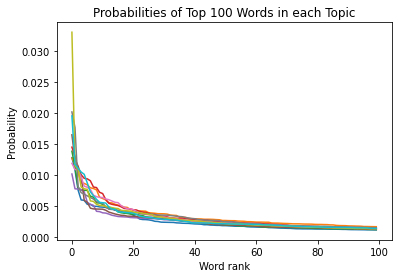

In [9]:
for i in range(10):
    plt.plot(range(100), topic_model.get_topics(topic_ids=[i], num_words=100)['score'])
plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.title('Probabilities of Top 100 Words in each Topic')

In the above plot, each line corresponds to one of our ten topics. Notice how for each topic, the weights drop off sharply as we move down the ranked list of most important words. This shows that the top 10-20 words in each topic are assigned a much greater weight than the remaining words - and remember from the summary of our topic model that our vocabulary has 547462 words in total!


Next we plot the total weight assigned by each topic to its top 10 words: 

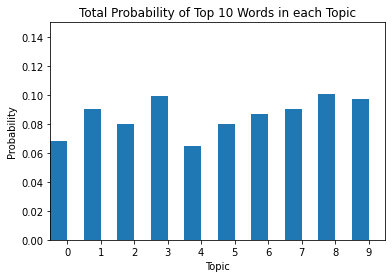

In [10]:
top_probs = [sum(topic_model.get_topics(topic_ids=[i], num_words=10)['score']) for i in range(10)]

ind = np.arange(10)
width = 0.5

fig, ax = plt.subplots()

ax.bar(ind-(width/2),top_probs,width)
ax.set_xticks(ind)

plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title('Total Probability of Top 10 Words in each Topic')
plt.xlim(-0.5,9.5)
plt.ylim(0,0.15)
plt.show()

Here we see that, for our topic model, the top 10 words only account for a small fraction (in this case, between 6% and 12%) of their topic's total probability mass. So while we can use the top words to identify broad themes for each topic, we should keep in mind that in reality these topics are more complex than a simple 10-word summary.

# Topic distributions for some example documents

As we noted in the introduction to this assignment, LDA allows for mixed membership, which means that each document can partially belong to several different topics. For each document, topic membership is expressed as a vector of weights that sum to one; the magnitude of each weight indicates the degree to which the document represents that particular topic.

We'll explore this in our fitted model by looking at the topic distributions for a few example Wikipedia articles from our data set. We should find that these articles have the highest weights on the topics whose themes are most relevant to the subject of the article - for example, we'd expect an article on a politician to place relatively high weight on topics related to government, while an article about an athlete should place higher weight on topics related to sports or competition.

Topic distributions for documents can be obtained using Turi Create's predict() function. Turi Create uses a collapsed Gibbs sampler similar to the one described in the video lectures, where only the word assignments variables are sampled.  To get a document-specific topic proportion vector post-facto, predict() draws this vector from the conditional distribution given the sampled word assignments in the document.  Notice that, since these are draws from a _distribution_ over topics that the model has learned, we will get slightly different predictions each time we call this function on a document - we can see this below, where we predict the topic distribution for the article on Barack Obama:

In [11]:
obama = turicreate.SArray([wiki_docs[int(np.where(wiki['name']=='Barack Obama')[0])]])
pred1 = topic_model.predict(obama, output_type='probability')
pred2 = topic_model.predict(obama, output_type='probability')
print(turicreate.SFrame({'predictions (first draw)':pred1[0], 'predictions (second draw)':pred2[0]}))

+--------------------------+---------------------------+
| predictions (first draw) | predictions (second draw) |
+--------------------------+---------------------------+
|   0.03763440860215054    |    0.024193548387096774   |
|   0.03763440860215054    |    0.05913978494623656    |
|   0.026881720430107527   |    0.021505376344086023   |
|   0.40053763440860213    |     0.3172043010752688    |
|    0.3279569892473118    |    0.41935483870967744    |
|   0.021505376344086023   |    0.021505376344086023   |
|   0.04838709677419355    |    0.04032258064516129    |
|   0.043010752688172046   |    0.03763440860215054    |
|   0.03494623655913978    |    0.02956989247311828    |
|   0.021505376344086023   |    0.02956989247311828    |
+--------------------------+---------------------------+
[10 rows x 2 columns]



To get a more robust estimate of the topics for each document, we can average a large number of predictions for the same document:

In [12]:
def average_predictions(model, test_document, num_trials=100):
    avg_preds = np.zeros((model.num_topics))
    for i in range(num_trials):
        avg_preds += model.predict(test_document, output_type='probability')[0]
    avg_preds = avg_preds/num_trials
    result = turicreate.SFrame({'average predictions':avg_preds})
    result = result.sort('average predictions', ascending=False)
    return result

In [13]:
print(average_predictions(topic_model, obama, 100))

+----------------------+
| average predictions  |
+----------------------+
|  0.4039247311827956  |
|  0.3406720430107527  |
| 0.048790322580645196 |
| 0.039865591397849495 |
| 0.03841397849462368  |
| 0.03543010752688175  |
| 0.027822580645161302 |
| 0.02231182795698925  |
| 0.021612903225806442 |
| 0.02115591397849461  |
+----------------------+
[10 rows x 1 columns]



In [14]:
bush = turicreate.SArray([wiki_docs[int(np.where(wiki['name']=='George W. Bush')[0])]])
print(average_predictions(topic_model, bush, 100))

+----------------------+
| average predictions  |
+----------------------+
|  0.3449122807017544  |
| 0.32652046783625716  |
| 0.05833333333333334  |
| 0.054444444444444434 |
|  0.0539766081871345  |
| 0.03687134502923975  |
| 0.03666666666666667  |
| 0.03385964912280701  |
| 0.03257309941520467  |
| 0.02184210526315789  |
+----------------------+
[10 rows x 1 columns]



# Comparing LDA to nearest neighbors for document retrieval

So far we have found that our topic model has learned some coherent topics, we have explored these topics as probability distributions over a vocabulary, and we have seen how individual documents in our Wikipedia data set are assigned to these topics in a way that corresponds with our expectations. 

In this section, we will use the predicted topic distribution as a representation of each document, similar to how we have previously represented documents by word count or TF-IDF. This gives us a way of computing distances between documents, so that we can run a nearest neighbors search for a given document based on its membership in the topics that we learned from LDA. We can contrast the results with those obtained by running nearest neighbors under the usual TF-IDF representation. 

We'll start by creating the LDA topic distribution representation for each document:

In [15]:
wiki['lda'] = topic_model.predict(wiki_docs, output_type='probability')

In [16]:
wiki

URI,name,text,lda
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"[0.042328042328042326,0.656084656084656, ..."
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"[0.07567567567567568,0.04864864864864865, ..."
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"[0.04597701149425287,0.040229885057471264, ..."
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"[0.2813688212927757,0.07224334600760456, ..."
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"[0.05325443786982249,0.09467455621301775, ..."
<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...,"[0.1542056074766355,0.0794392523364486, ..."
<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...,"[0.03943661971830986,0.022535211267605635, ..."
<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...,"[0.24456521739130435,0.07065217391304347, ..."
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"[0.03940886699507389,0.04433497536945813, ..."
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"[0.16853932584269662,0.033707865168539325, ..."


Next we add the TF-IDF document representations:

In [17]:
wiki['word_count'] = turicreate.text_analytics.count_words(wiki['text'])
wiki['tf_idf'] = turicreate.text_analytics.tf_idf(wiki['word_count'])

For each of our two different document representations, we can use Turi Create to compute a brute-force nearest neighbors model:

In [18]:
model_tf_idf = turicreate.nearest_neighbors.create(wiki, label='name', features=['tf_idf'],
                                                   method='brute_force', distance='cosine')
model_lda_rep = turicreate.nearest_neighbors.create(wiki, label='name', features=['lda'],
                                                    method='brute_force', distance='cosine')

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Let's compare these nearest neighbor models by finding the nearest neighbors under each representation on an example document. For this example we'll use Paul Krugman, an American economist:

In [19]:
model_tf_idf.query(wiki[wiki['name'] == 'Paul Krugman'], label='name', k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 13.252ms     |

| Done         |         | 100         | 212.801ms    |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
Paul Krugman,Paul Krugman,0.0,1
Paul Krugman,Elise Brezis,0.7444980172622551,2
Paul Krugman,Maitreesh Ghatak,0.8156498483099809,3
Paul Krugman,Kai A. Konrad,0.8237005644064379,4
Paul Krugman,David Colander,0.8346259277590851,5
Paul Krugman,Richard Blundell,0.8379342678735122,6
Paul Krugman,Gordon Rausser,0.8394153470596016,7
Paul Krugman,Edward J. Nell,0.8421785000147988,8
Paul Krugman,Robin Boadway,0.8423742605956992,9
Paul Krugman,Tim Besley,0.8430881092528927,10


In [20]:
model_lda_rep.query(wiki[wiki['name'] == 'Paul Krugman'], label='name', k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 2.289ms      |

| Done         |         | 100         | 22.639ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
Paul Krugman,Paul Krugman,1.1102230246251565e-16,1
Paul Krugman,Kwak Jun-hyeok,0.004016406760560365,2
Paul Krugman,Francis Collins,0.004313655485743584,3
Paul Krugman,Susan B. Neuman,0.0047152944394937,4
Paul Krugman,Rupert Sheldrake,0.004768145499648435,5
Paul Krugman,Salman Akhtar,0.0051717086301407145,6
Paul Krugman,Bill Hilf,0.005249225798390156,7
Paul Krugman,Chandramauli Upadhyay,0.005267625163722478,8
Paul Krugman,Noam Chomsky,0.005885817369712831,9
Paul Krugman,Karen Orren,0.006376308806473552,10


Notice that that there is no overlap between the two sets of top 10 nearest neighbors. This doesn't necessarily mean that one representation is better or worse than the other, but rather that they are picking out different features of the documents. 

With TF-IDF, documents are distinguished by the frequency of uncommon words. Since similarity is defined based on the specific words used in the document, documents that are "close" under TF-IDF tend to be similar in terms of specific details. This is what we see in the example: the top 10 nearest neighbors are all economists from the US, UK, or Canada. 

Our LDA representation, on the other hand, defines similarity between documents in terms of their topic distributions. This means that documents can be "close" if they share similar themes, even though they may not share many of the same keywords. For the article on Paul Krugman, we expect the most important topics to be 'American college and politics' and 'science and research'. As a result, we see that the top 10 nearest neighbors are academics from a wide variety of fields, including literature, anthropology, and religious studies.